In [273]:
import sklearn
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier

from sklearn.tree import plot_tree
from joblib import dump, load

In [274]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [275]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [276]:
num_feats = ["age", "creatinine_phosphokinase", "serum_sodium", "time", "platelets", "ejection_fraction",
             "serum_creatinine"]
cat_feats = ["anaemia", "high_blood_pressure", "diabetes", "sex", "smoking"]

<Figure size 1440x1440 with 0 Axes>

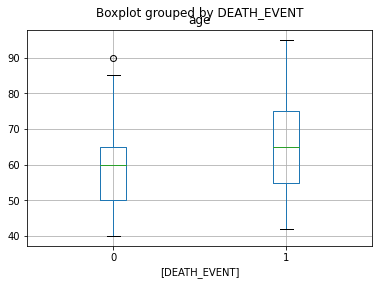

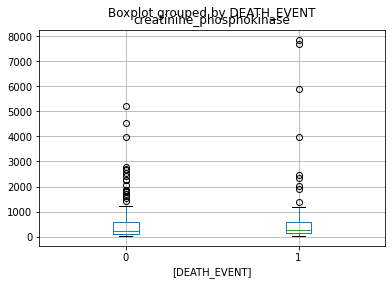

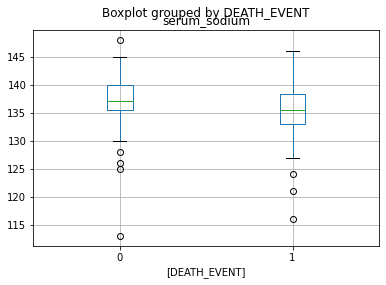

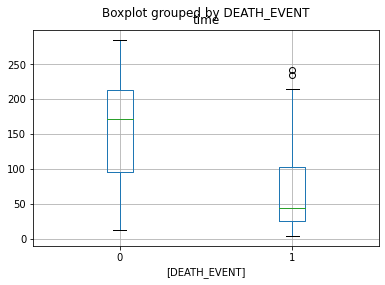

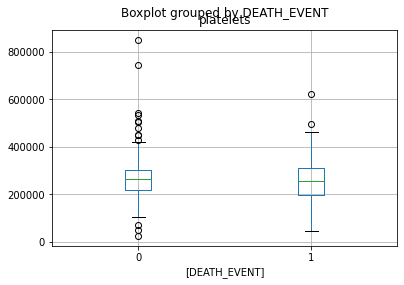

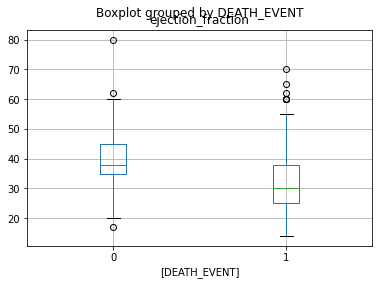

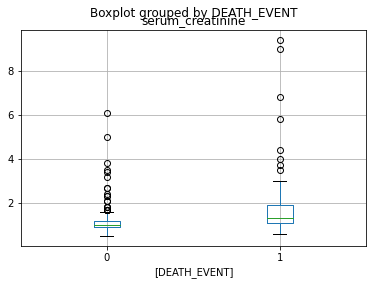

In [277]:
plt.figure(figsize=(20, 20))
for feat in num_feats:
    df[[feat, "DEATH_EVENT"]].boxplot(by="DEATH_EVENT");

In [278]:
df["DEATH_EVENT"].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [279]:
n_rows = df.shape[0]
# shuffle rows
df = df.sample(n_rows)
df["DEATH_EVENT"].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [280]:
n_train = int(n_rows * 0.8)
n_test = n_rows - n_train
train_df = df.head(n_train)
test_df = df.tail(n_test)

In [281]:
feats = df.columns.tolist()
target = "DEATH_EVENT"
feats.remove(target)

X_train = train_df[feats]
y_train = train_df[target]

X_test = test_df[feats]
y_test = test_df[target]

In [282]:
scale = ColumnTransformer(transformers=[
    ('scale', StandardScaler(), num_feats)],
    remainder='passthrough'
)

In [283]:
def train_model(model):
    model = model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print(classification_report(y_train, y_train_pred))
    print(classification_report(y_test, y_test_pred))

In [284]:
log_reg = Pipeline(steps=[
    ('scale', scale),
    ('classify',
     GridSearchCV(LogisticRegression(),
                  param_grid={"C": [0.001, 0.01, 0.1, 1, 10, 100]},
                  refit=True,
                  scoring="f1")
    )
])

svm = Pipeline(steps=[
    ('scale', scale),
    ('classify',
     GridSearchCV(SVC(),
                  param_grid={"C": [0.001, 0.01, 0.1, 1, 10], "kernel": ["linear", "rbf"]},
                  refit=True, scoring="f1")
    )
])

tree = Pipeline(steps=[
    ('scale', scale),
    ('classify', GridSearchCV(DecisionTreeClassifier(),
                              param_grid={"max_depth": [2, 4, 5, 6, 7, 8, 9, 10, 12]},
                              refit=True, scoring="f1"))
])

mlp = Pipeline(steps=[
    ('scale', scale),
    ('classify', GridSearchCV(MLPClassifier(),
                              param_grid={"hidden_layer_sizes": [10, 20, 30, 40],
                                          "learning_rate": ["adaptive"],
                                          "alpha": [1e-3, 1e-4, 1e-5],
                                          "solver": ["lbfgs"],
                                          "max_iter": [500],
                                         },
                              refit=True, scoring="f1")
    )
])

In [285]:
train_model(svm)

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       162
           1       0.79      0.68      0.73        77

    accuracy                           0.84       239
   macro avg       0.82      0.79      0.81       239
weighted avg       0.83      0.84      0.83       239

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        41
           1       0.85      0.89      0.87        19

    accuracy                           0.92        60
   macro avg       0.90      0.91      0.91        60
weighted avg       0.92      0.92      0.92        60



In [286]:
train_model(log_reg)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       162
           1       0.78      0.66      0.72        77

    accuracy                           0.83       239
   macro avg       0.82      0.79      0.80       239
weighted avg       0.83      0.83      0.83       239

              precision    recall  f1-score   support

           0       0.93      0.98      0.95        41
           1       0.94      0.84      0.89        19

    accuracy                           0.93        60
   macro avg       0.94      0.91      0.92        60
weighted avg       0.93      0.93      0.93        60



In [287]:
train_model(tree)

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       162
           1       0.81      0.68      0.74        77

    accuracy                           0.85       239
   macro avg       0.83      0.80      0.81       239
weighted avg       0.84      0.85      0.84       239

              precision    recall  f1-score   support

           0       0.83      0.98      0.90        41
           1       0.92      0.58      0.71        19

    accuracy                           0.85        60
   macro avg       0.88      0.78      0.80        60
weighted avg       0.86      0.85      0.84        60



In [288]:
train_model(mlp)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       162
           1       1.00      1.00      1.00        77

    accuracy                           1.00       239
   macro avg       1.00      1.00      1.00       239
weighted avg       1.00      1.00      1.00       239

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        41
           1       0.71      0.63      0.67        19

    accuracy                           0.80        60
   macro avg       0.77      0.75      0.76        60
weighted avg       0.80      0.80      0.80        60



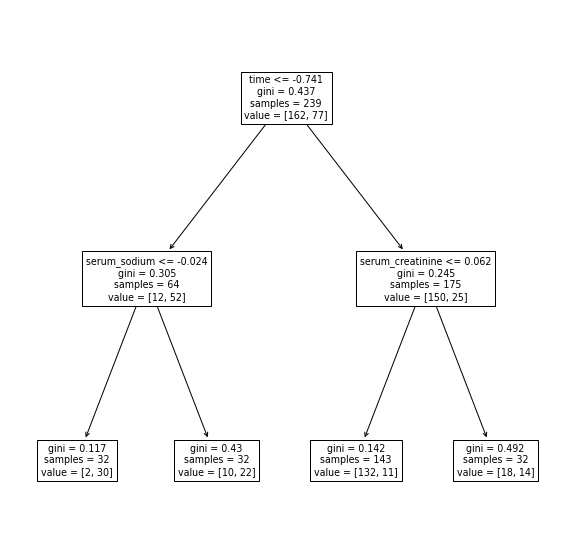

In [289]:
plt.figure(figsize=(10,10))
feat_names = df.columns[:-1]
t = tree.steps[1][1].best_estimator_
plot_tree(t, feature_names=num_feats + cat_feats);

In [290]:
dump(tree, "tree.joblib")
dump(svm, "svm.joblib")
dump(log_reg, "log_reg.joblib")

['log_reg.joblib']